In [4]:
from typing import Iterator, NamedTuple

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%env XLA_PYTHON_CLIENT_PREALLOCATE=false

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


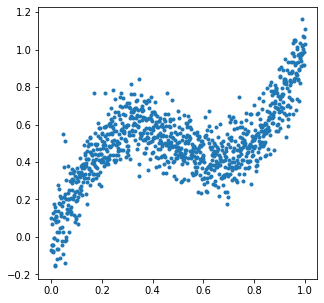

In [5]:
# Let's create some fake timeseries data that can have multiple y-values per x - so this is difficult
# to model with a simple MSE or single distribution network.

AMPLITUDE = 0.3

plt.figure(figsize=[5, 5])

NUM_TIME_POINTS = 1000

t=np.linspace(0., 1., NUM_TIME_POINTS)

# A simple sin function with some random noise
x = t + AMPLITUDE * np.sin(2*np.pi*t)+np.random.randn(NUM_TIME_POINTS)*0.1

plt.scatter(t, x, marker='.')

# Now make many of these for training

NUM_SAMPS = 20

X_Data = np.zeros((NUM_SAMPS, NUM_TIME_POINTS))
Y_Data = np.zeros((NUM_SAMPS, NUM_TIME_POINTS))

for i in range(NUM_SAMPS):
  X_Data[i, :] = t
  Y_Data[i, :] = t + AMPLITUDE * np.sin(2*np.pi*t)+np.random.randn(NUM_TIME_POINTS)*0.1

(20000, 1)


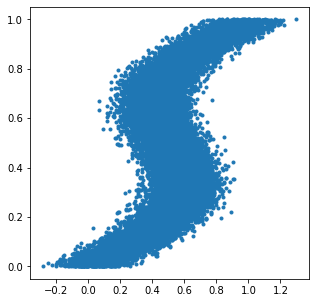

In [6]:
# standardize the data to prepare for inference
X_Data = jnp.expand_dims(X_Data.ravel(), axis=-1)
Y_Data = jnp.expand_dims(Y_Data.ravel(), axis=-1)

print(Y_Data.shape)

scaler = StandardScaler()

X_norm = scaler.fit_transform(X_Data)

# However, if we consider the inverse problem, we cannot fit a good model of the data with just a mean squared error loss.  To demonstrate,
# we retrain the network, swapping x, and y

X_Data_md = Y_Data
Y_Data_md = X_Data

plt.figure(figsize=[5, 5])

plt.scatter(X_Data_md, Y_Data_md, marker='.')

In [7]:
# It will be easier to feed into Jax/Haiku if we use the tensorflow dataset tools
BATCH = 64

data = tf.data.Dataset.from_tensor_slices((X_Data_md, Y_Data_md))
data = data.batch(BATCH)

In [ ]:
# To prove that, let's try and train a MSE network in JAX - This code structure is right form the Haiku
# examples.

EPOCHS = 25

# Just a standard MLP with decent capacity - Not an amazing example of a neural network because the logits
# are arbitrary and MSE is not the best loss function to minimize
def net_fn(x: jnp.ndarray) -> jnp.ndarray:
  mlp = hk.Sequential([
      hk.Linear(256), jax.nn.relu,
      hk.Linear(128), jax.nn.relu,
      hk.Linear(1),
  ])
  return mlp(x)

network = hk.without_apply_rng(hk.transform(net_fn))
optimiser = optax.rmsprop(1e-3)

@jax.jit
def loss(params: hk.Params, batch: tuple) -> jnp.ndarray:
    # Trying to predict y
    logits = network.apply(params, batch[0])
    loss = optax.l2_loss(logits, batch[1])

    # MSE / L2_Loss
    #loss = (logits - batch[1])**2

    return jnp.mean(loss)

@jax.jit
def update(params: hk.Params, opt_state: optax.OptState, batch: tuple):
  grad = jax.grad(loss)(params, batch)
  updates, opt_state = optimiser.update(grad, opt_state)
  params = optax.apply_updates(params, updates)

  return params, opt_state

b = data.as_numpy_iterator()
params = network.init(jax.random.PRNGKey(seed=42), next(b)[0])
opt_state = optimiser.init(params)

for step in range(EPOCHS):
  data_iter = data.as_numpy_iterator()

  print({"Epoch": step})
  for b in data_iter:
    params, opt_state = update(params, opt_state, b)

  # Average loss?
  data_iter = data.as_numpy_iterator()
  total_loss = 0
  for b in data_iter:
    total_loss = total_loss + loss(params, b)

  print("   loss {:0.4f}".format(total_loss*BATCH/20000))


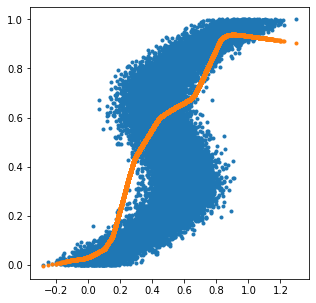

In [9]:
# You can see that because there are multiple y for every x, the network can only compute
# an approximate average with MSE, but it doesn't follow the curve.

y_pred = network.apply(params, X_Data_md)

plt.figure(figsize=[5, 5])

plt.scatter(X_Data_md[:, 0], Y_Data_md, marker='.')

plt.scatter(X_Data_md[:, 0], y_pred, marker='.')

In [ ]:
# So we will need to redefine our network to output the paramaters of a mixture density function, which
# will not only allow for more than one y per x, but also predicting a distribution is a much more natural
# method for training a neural network.

EPOCHS = 150

NUM_COMPONENTS = 5

# Assuming independence between distributions (i.e., no correlation component), we need to parameterize 
# means (mus), variances (sigmas), and mixing components (phis)
params_size = NUM_COMPONENTS + NUM_COMPONENTS + NUM_COMPONENTS

def net_fn(x: jnp.ndarray) -> jnp.ndarray:
  mlp = hk.Sequential([
      hk.Linear(256), jax.nn.relu,
      hk.Linear(128), jax.nn.relu,
      hk.Linear(params_size),
  ])
  return mlp(x)

network = hk.without_apply_rng(hk.transform(net_fn))

# Combining gradient transforms using `optax.chain`.
optimiser = optax.chain(
    optax.adam(0.0003)
)

EPS = 0.00000001

# Custom loss function. See Bishop, 1994 and https://github.com/sjvasquez/handwriting-synthesis for a 
# tensorflow example and some excellent code. The idea to clip the values came from that repository.
@jax.jit
def loss(params: hk.Params, batch: tuple) -> jnp.ndarray:
    # Trying to predict y
    logits = network.apply(params, batch[0])

    y_true = batch[1]

    pis, mu, sig = jnp.array_split(logits, [NUM_COMPONENTS, NUM_COMPONENTS*2], axis=-1)

    # weights - must be a probability distribution so softmax over all components
    pis = jax.nn.softmax(pis)

    # means - no transformation needed

    # standard deviations - must be strictly positive so exponent
    sig = jnp.exp(sig)

    # We can get some divide by zero issues in here so we need to watch for that and clip the values to 
    # something sensible
    sig = jnp.clip(sig, EPS, np.inf)

    # Now form Gaussian mixtures - Bishop 2014, equation 23
    term1 = 1. / ( jax.lax.pow( 2. * np.pi, 0.5) * sig )
    term2 = jnp.exp(( -1. * jnp.square(y_true - mu)) / (2. * jnp.square(sig)))

    # Now the loss function - the sum over the individual Gaussian components - Bishop 2014, equation 29
    # Luckily, we do not need to hand roll the differentiation, as Tensorflow will take care of that for us as long as we use tf functions in all
    # of our arthmetic

    mix_loss = jnp.sum(pis * term1 * term2, axis=-1)
    #mix_loss = jnp.expand_dims(mix_loss, axis=-1)

    mix_loss = jnp.clip(mix_loss, EPS, np.inf)

    # As always, we use the log-loss
    return jnp.mean(-jnp.log(mix_loss))

@jax.jit
def update(params: hk.Params, opt_state: optax.OptState, batch: tuple):
  grad = jax.grad(loss)(params, batch)
  updates, opt_state = optimiser.update(grad, opt_state)
  params = optax.apply_updates(params, updates)

  return params, opt_state

b = data.as_numpy_iterator()
params = network.init(jax.random.PRNGKey(seed=0), next(b)[0])
opt_state = optimiser.init(params)

for step in range(EPOCHS):
  data_iter = data.as_numpy_iterator()

  print({"Epoch": step})
  for b in data_iter:
    params, opt_state = update(params, opt_state, b)

  # Average loss?
  data_iter = data.as_numpy_iterator()
  total_loss = 0
  for b in data_iter:
    total_loss = total_loss + loss(params, b)

  print("   loss {:0.4f}".format(total_loss*BATCH/20000))

In [20]:
# We also need our own sampling function in this case
from tensorflow_probability.substrates import jax as tfp

# sample the mixture model
# input: res (mixture_components)
# output: sample, pis, mean, variance
def sample_mix_model(res):
  #print(res.shape)
  pis, mu, sig = jnp.array_split(res, [NUM_COMPONENTS, NUM_COMPONENTS*2], axis=-1)

  # weights - must be a probability distribution so softmax over all components
  pis = jax.nn.softmax(pis)

  # means - no transformation needed

  # standard deviations - must be strictly positive so exponent
  sig = jnp.exp(sig)

  # The distribution is a mixture of gaussians
  gm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(probs=pis),
        components_distribution=tfp.distributions.Normal(mu, sig))

  #print(gm.sample(seed=jaxs.random.PRNGKey(seed=42)))

  return gm.sample(seed=jax.random.PRNGKey(seed=42)), pis, gm.components_distribution.mean(), gm.components_distribution.variance()

In [21]:
t.shape

(1000,)

In [22]:
tfp

<module 'tensorflow_probability.substrates.jax' from '/home/don/ML-tests/lib/python3.8/site-packages/tensorflow_probability/substrates/jax/__init__.py'>

In [23]:
y_pred_mix = network.apply(params, jnp.expand_dims(t, -1))

In [24]:
y_pred = jnp.apply_along_axis(sample_mix_model, 1, y_pred_mix)

In [25]:
y_cat = jnp.argmax(y_pred[1], -1)

jnp.unique(y_cat)

DeviceArray([0, 1, 4], dtype=int32)

In [26]:
y_pred_means = y_pred[2]

y_dist = y_pred_means[np.arange(1000), y_cat]

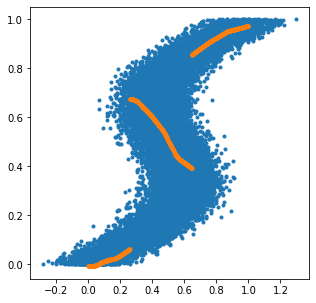

In [27]:
# Here we reproduce Bishop, 1994, Figure 10 where we plot the mean of the most probably distribution.  We see that this is a piece-wise function,
# just as in Bishop, 1994

plt.figure(figsize=[5, 5])

plt.scatter(X_Data_md[:, 0], Y_Data_md, marker='.')

#plt.scatter(t, y_pred.sample(), marker='.')

plt.scatter(t, y_dist, marker='.')